In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from time import time
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm

In [26]:
df_store=pd.read_csv(r"C:\Users\Basel\Desktop\Data Analysis Projects\Predicting Sales Time Series Analysis & Forecasting with Python\store.csv")

In [27]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [28]:
df_train=pd.read_csv(r"C:\Users\Basel\Desktop\Data Analysis Projects\Predicting Sales Time Series Analysis & Forecasting with Python\train.csv")

In [29]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [30]:
df_train_merged=df_train.merge(df_store,on='Store')

In [31]:
df_train_merged['Date']=pd.to_datetime(df_train_merged['Date'])

In [38]:
df_train_merged.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                       category
SchoolHoliday                         int64
StoreType                          category
Assortment                         category
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                      category
dtype: object

In [33]:
df_train_merged['StateHoliday']=pd.Categorical(df_train_merged['StateHoliday'])

In [34]:
df_train_merged['StoreType']=pd.Categorical(df_train_merged['StoreType'])

In [35]:
df_train_merged['Assortment']=pd.Categorical(df_train_merged['Assortment'])

In [37]:
df_train_merged['PromoInterval']=pd.Categorical(df_train_merged['PromoInterval'])

In [40]:
df_train_merged['StateHoliday']=df_train_merged['StateHoliday'].cat.codes
df_train_merged['StoreType']=df_train_merged['StoreType'].cat.codes
df_train_merged['Assortment']=df_train_merged['Assortment'].cat.codes
df_train_merged['PromoInterval']=df_train_merged['PromoInterval'].cat.codes

In [55]:
df_train_merged['isWeekend']=df_train_merged['DayOfWeek'].apply(lambda x: 1 if x==7 else 0)

In [56]:
df_corr=df_train_merged.corr(method='pearson')

Text(0.5, 1.0, 'Pearson Correlation OF Sales and Other Variables')

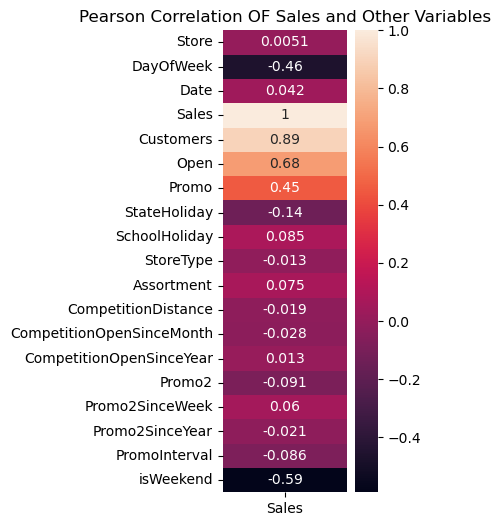

In [223]:
plt.figure(figsize=(2,6))
sns.heatmap(data=df_corr[['Sales']],annot=True)
plt.title('Pearson Correlation OF Sales and Other Variables')

In [66]:
df_test=pd.read_csv(r"C:\Users\Basel\Desktop\Data Analysis Projects\Predicting Sales Time Series Analysis & Forecasting with Python\test.csv")

In [84]:
df_train=df_train_merged[['Store','Sales','DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday']]

In [74]:
df_test.drop(columns=['Id'],inplace=True)

In [71]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [88]:
df_store_train=df_train[df_train['Store']==1].set_index('Date').sort_index(ascending=True)

In [89]:
df_store_test=df_test[df_test['Store']==1].set_index('Date').sort_index(ascending=True)

In [95]:
decomposition=seasonal_decompose(df_store_train['Sales'],model='Additive',period=365)

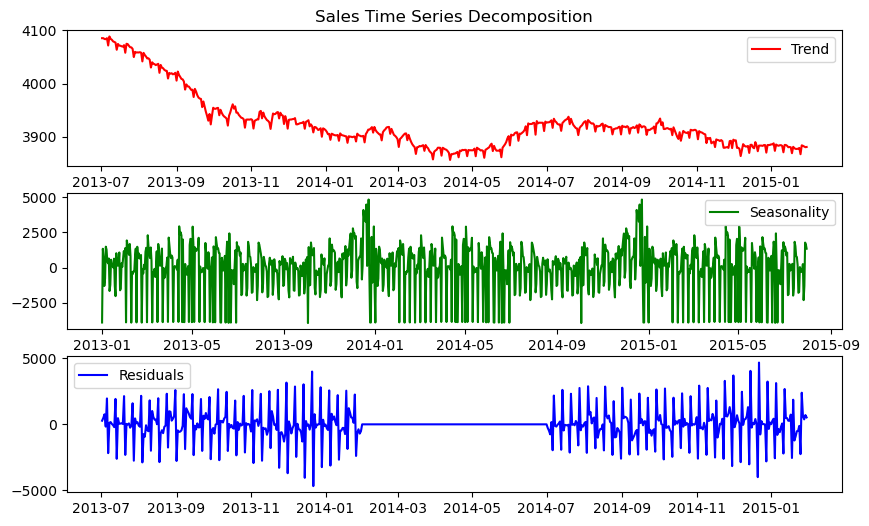

In [133]:
fig,axs=plt.subplots(nrows=3,ncols=1,figsize=(10,6))
axs[0].plot(decomposition.trend,color='Red',label='Trend')
axs[0].legend()
axs[0].set_title('Sales Time Series Decomposition')
axs[1].plot(decomposition.seasonal,color='Green',label='Seasonality')
axs[1].legend()
axs[2].plot(decomposition.resid,color='Blue',label='Residuals')
axs[2].legend()

In [224]:
def test_stationarity(df):
    roll_mean=df.rolling(window=7).mean()
    roll_std=df.rolling(window=7).std()
    plt.figure(figsize=(10,5))
    plt.plot(df.resample('W').sum(),label='Actual')
    plt.plot(roll_mean.resample('W').sum(),label='Mean')
    plt.plot(roll_std.resample('W').sum(),label='STD')
    plt.xticks(rotation=45)
    plt.title('Testing Time Series Stationarity')
    plt.legend()
    
    result=adfuller(df,autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    # Conclusion based on p-value
    if result[1] < 0.05:
        print("\nThe time series is stationary.")
    else:
        print("\nThe time series is not stationary.")

ADF Statistic: -4.368104
p-value: 0.000338
Critical Values:
   1%: -3.4374778690219956
   5%: -2.864686684217556
   10%: -2.5684454926748583

The time series is stationary.


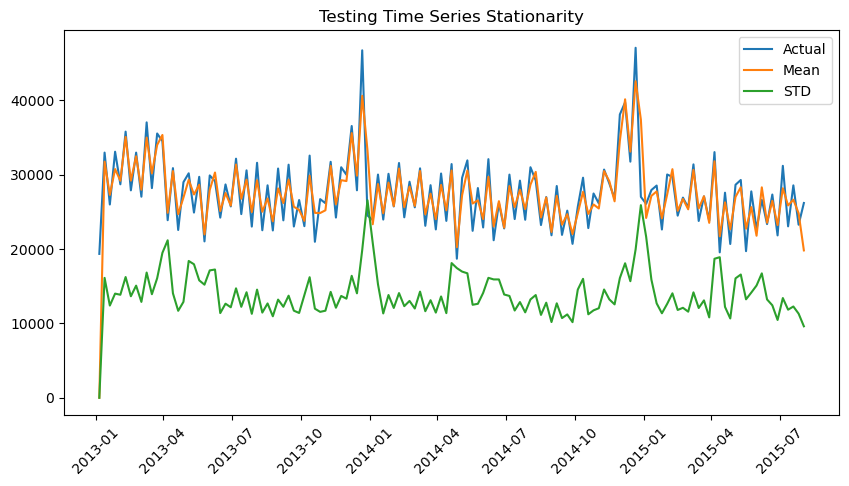

In [225]:
test_stationarity(df_store_train['Sales'])

In [135]:
y_train=df_store_train[['Sales']]

In [137]:
exgo_train=df_store_train.drop(columns=['Sales'])

In [169]:
model=pm.auto_arima(df_store_train['Sales'],exogenous=exgo_train,seasonal=True,m=7,trace=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17010.848, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16885.167, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16798.332, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=18493.698, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=16997.035, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=16780.005, Time=1.59 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=16949.361, Time=0.42 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=16511.044, Time=3.60 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=16223.971, Time=3.36 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=16914.032, Time=1.18 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,0,2)(2,0,0)[7] intercept   : AIC=16301.170, Time=3.34 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=16744.992, Time=3.70 sec
 ARIMA(1,0,2)(2,0,0)[7] interce

In [174]:
model_sarimax = sm.tsa.statespace.SARIMAX(y_train,exog=exgo_train,order=(1,1,1)
                                          ,seasonal_order=(1,1,1,7),enforce_stationarity=False)
sarimax_results=model_sarimax.fit()
print(sarimax_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7256.274
Date:                           Sun, 30 Jun 2024   AIC                          14534.549
Time:                                   21:15:12   BIC                          14587.676
Sample:                               01-01-2013   HQIC                         14554.817
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Store            -0.0358   1.11e+04  -3.22e-06      1.000   -2.17e+04    2.17e+04
DayOfWeek         0.3894   1783.43

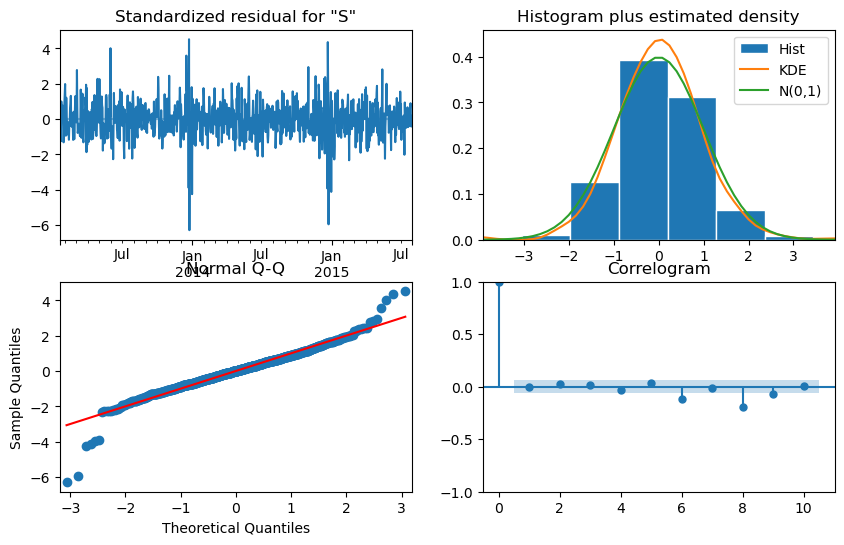

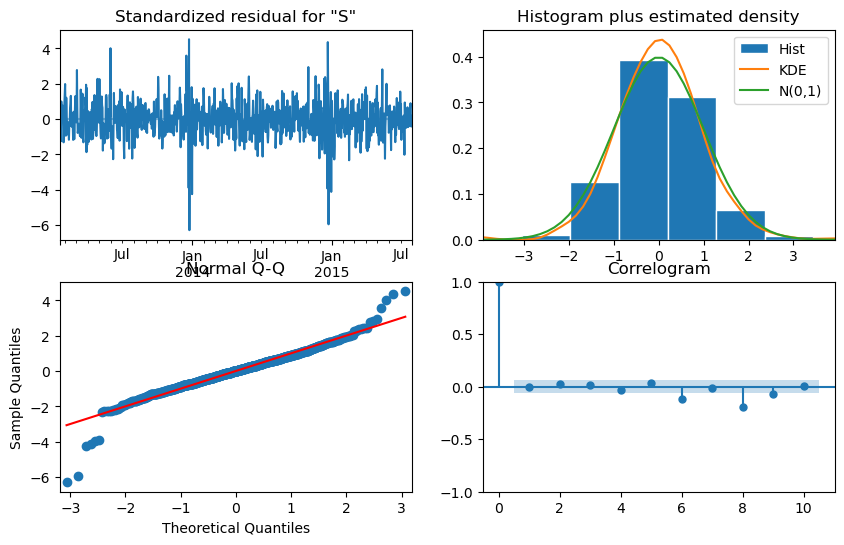

In [185]:
sarimax_results.plot_diagnostics(figsize=(10,6))

In [189]:
pred=sarimax_results.get_prediction(start='2015-01-01',end='2015-07-31')

In [198]:
predictions=pred.predicted_mean

In [215]:
pred_ci=pred.conf_int().rolling(window=7).sum()

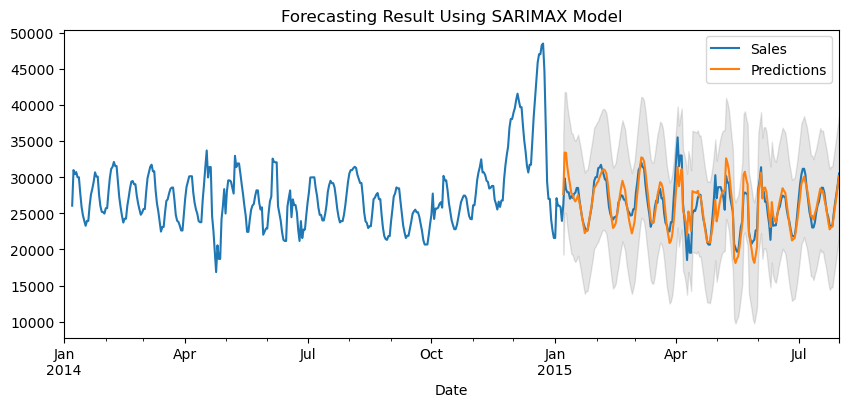

In [226]:
ax=y_train["2014":].rolling(window=7).sum().plot(figsize=(10,4))
predictions.rolling(window=7).sum().plot(ax=ax,label='Predictions')
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color = "k", alpha = 0.1)
plt.title('Forecasting Result Using SARIMAX Model')
plt.legend()